# ED LOS Statistics

## Load Dataset + Packages

In [60]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
from scipy.stats import ttest_ind
from imblearn.combine import SMOTETomek


pd.set_option('display.max_columns', 100)  # 

In [61]:
df_master = pd.read_csv('df_master_imputed_iter_new.csv')

In [62]:
# Round off all the decimal values in the 'triage_acuity' column
df_master['triage_acuity_iter'] = df_master['triage_acuity_iter'].round()

# Check the unique values in the 'triage_acuity' column after rounding off
unique_values_rounded = df_master['triage_acuity_iter'].unique()
print(unique_values_rounded)

[ 3.  2.  4.  1.  5. -0.]


In [63]:
# Define the threshold for LOS classification
threshold = 4.5  # Define your threshold value here (in hours)

# Create a new binary variable indicating short or long stays
df_master['LOS_category'] = df_master['ed_los_hours_iter'].apply(lambda x: 'short' if x <= threshold else 'long')

# Optionally, encode the binary variable as 0s and 1s
df_master['LOS_category_encoded'] = df_master['LOS_category'].map({'short': 0, 'long': 1})

# Display the counts of each category
print(df_master['LOS_category'].value_counts())

LOS_category
long     252029
short    158898
Name: count, dtype: int64


In [64]:
df_train= df_master.sample(frac=0.8,random_state=10) #set seed
df_test= df_master.drop(df_train.index)

## Baseline Statistics

Firstly, we calculate the baseline characteristics of the whole dataset

In [65]:
df_master[['triage_dbp_iter', 'triage_dbp']].describe()


,triage_dbp_iter,triage_dbp
count,410927.000000,392590.000000
mean,77.395660,77.458206
std,14.694691,14.946127
min,0.000000,0.000000
25%,68.000000,68.000000
50%,77.000000,77.000000
75%,86.194811,87.000000
max,375.000000,375.000000


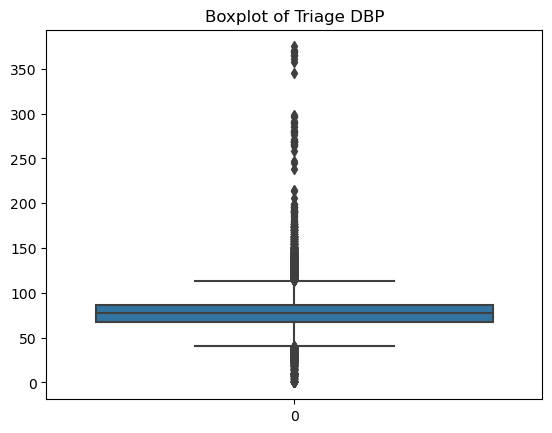

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(df_master['triage_dbp_iter'])
plt.title('Boxplot of Triage DBP')
plt.show()


In [81]:
#df_master

In [67]:
import pandas as pd

# Define the variables list
variables = ["age", "gender_encoded", "cci_score", "eci_score",
             "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
             "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",
             "triage_temperature_iter", "triage_heartrate_iter", "triage_resprate_iter",
             "triage_o2sat_iter", "triage_sbp_iter", "triage_dbp_iter", "triage_pain_iter", "triage_acuity_iter",
             "ed_temperature_last_iter", "ed_heartrate_last_iter", "ed_resprate_last_iter", "ed_o2sat_last_iter",
             "ed_sbp_last_iter", "ed_dbp_last_iter", "ed_pain_last_iter",
             "med_event", "outcome_hospitalization", "outcome_critical","gender","outcome_ed_revisit_3d",
            "outcome_icu_transfer_12h","outcome_inhospital_mortality","LOS_category"]

categorical_variables = ["gender", "outcome_ed_revisit_3d", "med_event", "outcome_hospitalization", "outcome_critical",
                         "outcome_icu_transfer_12h","outcome_inhospital_mortality","LOS_category"]

# Function to compute statistics for numerical variables
def compute_numerical_stats(df, var):
    return df[var].mean(), df[var].std()

# Function to compute statistics for categorical variables
def compute_categorical_stats(df, var):
    counts = df[var].value_counts()
    percentages = df[var].value_counts(normalize=True) * 100
    return counts, percentages

# Dictionary to store the results
results = {}

# Compute statistics
for var in variables:
    if var in categorical_variables:
        counts, percentages = compute_categorical_stats(df_master, var)
        results[var] = {'Counts': counts.to_dict(), 'Percentages': percentages.to_dict()}
    else:
        mean, std = compute_numerical_stats(df_master, var)
        results[var] = {'Mean': mean, 'Std Dev': std}

# Print the results
for var, stats in results.items():
    print(f"Variable: {var}")
    if 'Mean' in stats:
        print(f"  Mean: {stats['Mean']}")
        print(f"  Std Dev: {stats['Std Dev']}")
    else:
        print("  Counts:")
        for k, v in stats['Counts'].items():
            print(f"    {k}: {v}")
        print("  Percentages:")
        for k, v in stats['Percentages'].items():
            print(f"    {k}: {v:.2f}%")
    print()

Variable: age
  Mean: 52.768586634609065
  Std Dev: 20.608776351990933

Variable: gender_encoded
  Mean: 0.4589841991399932
  Std Dev: 0.4983154707277417

Variable: cci_score
  Mean: 1.3748378665797087
  Std Dev: 2.6319786020434277

Variable: eci_score
  Mean: 3.098399472412375
  Std Dev: 4.789939791567895

Variable: n_ed_30d
  Mean: 0.23762128066542232
  Std Dev: 0.7835596352360459

Variable: n_ed_90d
  Mean: 0.5277044341209023
  Std Dev: 1.6050551133218163

Variable: n_ed_365d
  Mean: 1.3979465939205746
  Std Dev: 4.21356914653612

Variable: n_hosp_30d
  Mean: 0.1572201388567799
  Std Dev: 0.5150207610244796

Variable: n_hosp_90d
  Mean: 0.36158490437474294
  Std Dev: 1.0336267938528831

Variable: n_hosp_365d
  Mean: 0.9679286101911045
  Std Dev: 2.704140938806648

Variable: n_icu_30d
  Mean: 0.020371014803115883
  Std Dev: 0.15617289605617052

Variable: n_icu_90d
  Mean: 0.04813993726379625
  Std Dev: 0.2671967614082772

Variable: n_icu_365d
  Mean: 0.11297627072448391
  Std Dev: 0.

## Statistics by Outcome (Short/Long)

now we calculate the statistics by outcome ED_LOS for the important variables found by GB importance eariler

In [69]:
#chosen variables
variable = ['triage_acuity_iter', 'disposition_ADMITTED', 'arrival_transport_UNKNOWN', 'eci_score', 
 'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE', 'age', 'med_event', 
 'disposition_LEFT WITHOUT BEING SEEN', 'disposition_HOME']



### continous variables


In [70]:
continuous_vars = variable = ['triage_acuity_iter','age','eci_score']
# Create a table to store the results
table = []

# Calculate mean and standard deviation for each continuous variable
for variable in continuous_vars:
    # Calculate mean and standard deviation for ED LOS LONG cases
    outcome_ed_los_mean = df_master[df_master['LOS_category_encoded'] == 1][variable].mean()
    outcome_ed_los_std = df_master[df_master['LOS_category_encoded'] == 1][variable].std()
    
    # Calculate mean and standard deviation for ED LOS SHORT cases
    outcome_ed_los_short_mean = df_master[df_master['LOS_category_encoded'] == 0][variable].mean()
    outcome_ed_los_short_std = df_master[df_master['LOS_category_encoded'] == 0][variable].std()
        # Append results to the table
    table.append([variable, "ED LOS LONG", f"{outcome_ed_los_mean:.2f}", f"{outcome_ed_los_std:.2f}"])
    table.append([variable, "ED LOS SHORT", f"{outcome_ed_los_short_mean:.2f}", f"{outcome_ed_los_short_std:.2f}"])
# Display the table
headers = ["Variable", "Outcome", "Mean", "Standard Deviation"]
print(tabulate(table, headers=headers, tablefmt="pretty"))

+--------------------+--------------+-------+--------------------+
|      Variable      |   Outcome    | Mean  | Standard Deviation |
+--------------------+--------------+-------+--------------------+
| triage_acuity_iter | ED LOS LONG  | 2.54  |        0.63        |
| triage_acuity_iter | ED LOS SHORT | 2.78  |        0.79        |
|        age         | ED LOS LONG  | 55.65 |       20.17        |
|        age         | ED LOS SHORT | 48.19 |       20.47        |
|     eci_score      | ED LOS LONG  | 3.73  |        5.10        |
|     eci_score      | ED LOS SHORT | 2.10  |        4.06        |
+--------------------+--------------+-------+--------------------+


### categorical variables


In [72]:
#refer to output


# List of categorical variables
categorical_vars = [ 'arrival_transport_UNKNOWN', 'disposition_ADMITTED', 'chiefcom_abdominal_pain', 
            'arrival_transport_AMBULANCE', 'med_event', 'disposition_HOME', 'disposition_LEFT WITHOUT BEING SEEN']

# Calculate counts and percentages for each categorical variable
for variable in categorical_vars:
    # Calculate total counts
    total_counts = df_master[variable].count()

    # Calculate counts for Long Stay
    hospitalization_counts = df_master[df_master['LOS_category_encoded'] == 1][variable].value_counts()
    hospitalization_percentage = hospitalization_counts / hospitalization_counts.sum() * 100


    # Calculate counts for Short Stay
    no_hospitalization_counts = df_master[df_master['LOS_category_encoded'] == 0][variable].value_counts()
    no_hospitalization_counts_percentage = no_hospitalization_counts / no_hospitalization_counts.sum() * 100

    # Display the results
    print(f"Counts and Percentages for {variable} in LOS Cases:")
    print(f"Total Counts: {total_counts}")
   
    # Format Hospitalization Counts and Percentages
    print("LOS Long stay:")
    print(hospitalization_counts)
    print("LOS Long Stay Percentags:")
    print(hospitalization_percentage.apply(lambda x: f"{x:.2f}%"))
   
    # Format No ED Revisit Counts and Percentages
    print("LOS Short stay Counts:")
    print(no_hospitalization_counts)
    print("LOS Short Stay Percentages:")
    print(no_hospitalization_counts_percentage.apply(lambda x: f"{x:.2f}%"))
   
    print("\n" + "="*40 + "\n")

Counts and Percentages for arrival_transport_UNKNOWN in LOS Cases:
Total Counts: 410927
LOS Long stay:
arrival_transport_UNKNOWN
False    248695
True       3334
Name: count, dtype: int64
LOS Long Stay Percentags:
arrival_transport_UNKNOWN
False    98.68%
True      1.32%
Name: count, dtype: object
LOS Short stay Counts:
arrival_transport_UNKNOWN
False    148582
True      10316
Name: count, dtype: int64
LOS Short Stay Percentages:
arrival_transport_UNKNOWN
False    93.51%
True      6.49%
Name: count, dtype: object


Counts and Percentages for disposition_ADMITTED in LOS Cases:
Total Counts: 410927
LOS Long stay:
disposition_ADMITTED
False    139072
True     112957
Name: count, dtype: int64
LOS Long Stay Percentags:
disposition_ADMITTED
False    55.18%
True     44.82%
Name: count, dtype: object
LOS Short stay Counts:
disposition_ADMITTED
False    116061
True      42837
Name: count, dtype: int64
LOS Short Stay Percentages:
disposition_ADMITTED
False    73.04%
True     26.96%
Name: count, d

## Statistics by train/test split and overall

### Original Data

In [12]:
# Create a dictionary to store the statistics
statistics = {}
outcome_variable = 'LOS_category_encoded'
# Calculate statistics for the Training Data
statistics['Training Data'] = {
    'ED LOS LONG': f"{df_train[outcome_variable].sum()} ({df_train[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_train.shape[0] - df_train[outcome_variable].sum())} ({(1 - df_train[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Test Data
statistics['Test Data'] = {
    'ED LOS LONG': f"{df_test[outcome_variable].sum()} ({df_test[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_test.shape[0] - df_test[outcome_variable].sum())} ({(1 - df_test[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Total (by outcome)
statistics['Total (by outcome)'] = {
    'ED LOS LONG': f"{df_master[outcome_variable].sum()} ({df_master[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_master.shape[0] - df_master[outcome_variable].sum())} ({(1 - df_master[outcome_variable].mean()) * 100:.2f}%)"
}

# Create a DataFrame from the statistics dictionary
df_statistics = pd.DataFrame(statistics).transpose()

df_statistics

,ED LOS LONG,ED LOS SHORT
Training Data,201574 (61.32%),127168 (38.68%)
Test Data,50459 (61.40%),31726 (38.60%)
Total (by outcome),252033 (61.33%),158894 (38.67%)


### Tomeklink Sampling

In [28]:
outcome = 'LOS_category_encoded'


X_train = df_train[variable]
y_train = df_train[outcome]

X_test = df_test[variable]
y_test = df_test[outcome]

In [37]:
# Define feature columns and target outcome
X = df_master[variable]  
y = df_master[outcome]  

In [38]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [39]:
from imblearn.under_sampling import TomekLinks
import pandas as pd

# Apply Tomek Links to remove overlapping examples between classes
tomek = TomekLinks()
X_train_res, y_train_res = tomek.fit_resample(X_train, y_train)

# Compare class distributions before and after Tomek Links
original_class_distribution = y_train.value_counts()
resampled_class_distribution = pd.Series(y_train_res).value_counts()

print("Original class distribution:")
print(original_class_distribution)
print("\nClass distribution after Tomek Links:")
print(resampled_class_distribution)


Original class distribution:
LOS_category_encoded
1    201626
0    127115
Name: count, dtype: int64

Class distribution after Tomek Links:
LOS_category_encoded
1    201381
0    127115
Name: count, dtype: int64


In [40]:
# Create a DataFrame from the resampled y_train to calculate new statistics
df_train_res = pd.DataFrame({outcome_variable: y_train_res})

# Calculate statistics for the Training Data (Tomek Links)
statistics['Training Data (Tomek Links)'] = {
    'ED LOS LONG': f"{df_train_res[outcome_variable].sum()} ({df_train_res[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_train_res.shape[0] - df_train_res[outcome_variable].sum())} ({(1 - df_train_res[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Test Data (same as original since Tomek Links is not applied to test data)
statistics['Test Data (Tomek Links)'] = {
    'ED LOS LONG': f"{df_test[outcome_variable].sum()} ({df_test[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_test.shape[0] - df_test[outcome_variable].sum())} ({(1 - df_test[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Total (by outcome) (Tomek Links)
total_long_tomek = df_train_res[outcome_variable].sum() + df_test[outcome_variable].sum()
total_samples_tomek = df_train_res.shape[0] + df_test.shape[0]
statistics['Total (by outcome) (Tomek Links)'] = {
    'ED LOS LONG': f"{total_long_tomek} ({total_long_tomek / total_samples_tomek * 100:.2f}%)",
    'ED LOS SHORT': f"{total_samples_tomek - total_long_tomek} ({(total_samples_tomek - total_long_tomek) / total_samples_tomek * 100:.2f}%)"
}

# Create a DataFrame from the updated statistics dictionary
df_statistics_tomek = pd.DataFrame(statistics).transpose()

df_statistics_tomek


,ED LOS LONG,ED LOS SHORT
Training Data (Tomek Links),201381 (61.30%),127115 (38.70%)
Test Data (Tomek Links),50459 (61.40%),31726 (38.60%)
Total (by outcome) (Tomek Links),251840 (61.32%),158841 (38.68%)


In [31]:
# Combine the two DataFrames side by side
df_combined_statistics = pd.concat([df_statistics, df_statistics_tomek], axis=1)

# Rename the columns for clarity
df_combined_statistics.columns = ['ED LOS LONG (Original)', 'ED LOS SHORT (Original)', 
                                  'ED LOS LONG (Tomeklinks)', 'ED LOS SHORT (Tomeklinks)']

df_combined_statistics

,ED LOS LONG (Original),ED LOS SHORT (Original),ED LOS LONG (Tomeklinks),ED LOS SHORT (Tomeklinks)
Training Data,201574 (61.32%),127168 (38.68%),NaN,NaN
Test Data,50459 (61.40%),31726 (38.60%),NaN,NaN
Total (by outcome),252033 (61.33%),158894 (38.67%),NaN,NaN
Training Data (Tomek Links),NaN,NaN,201339 (61.29%),127168 (38.71%)
Test Data (Tomek Links),NaN,NaN,50459 (61.40%),31726 (38.60%)
Total (by outcome) (Tomek Links),NaN,NaN,251798 (61.31%),158894 (38.69%)


In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Define the classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Initialize 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store metrics for each fold
cv_accuracy_list = []
cv_auc_list = []
cv_specificity_list = []
cv_sensitivity_list = []
cv_f1_list = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train_res, y_train_res):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
    y_train_fold, y_val_fold = y_train_res.iloc[train_index], y_train_res.iloc[val_index]

    # Train the Gradient Boosting model
    gb_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_val_pred = gb_classifier.predict(X_val_fold)
    y_val_pred_prob = gb_classifier.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics for the validation set
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    f1 = f1_score(y_val_fold, y_val_pred)

    # Store metrics for each fold
    cv_accuracy_list.append(accuracy)
    cv_auc_list.append(auc_score)
    cv_specificity_list.append(specificity)
    cv_sensitivity_list.append(sensitivity)
    cv_f1_list.append(f1)

# Calculate average metrics across all folds
print("Cross-Validation Results (Gradient Boosting):")
print("Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_accuracy_list), np.std(cv_accuracy_list)))
print("AUC: {:.4f} (+/- {:.4f})".format(np.mean(cv_auc_list), np.std(cv_auc_list)))
print("Specificity: {:.4f} (+/- {:.4f})".format(np.mean(cv_specificity_list), np.std(cv_specificity_list)))
print("Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(cv_sensitivity_list), np.std(cv_sensitivity_list)))
print("F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1_list), np.std(cv_f1_list)))

# Evaluate on the original unused test set
gb_classifier.fit(X_train_res, y_train_res)
y_test_pred = gb_classifier.predict(X_test)
y_test_pred_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc_score = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_specificity = tn / (tn + fp)
test_sensitivity = tp / (tp + fn)
test_f1 = f1_score(y_test, y_test_pred)

# Display the test set metrics
print("\nTest Set Evaluation (Gradient Boosting):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc_score:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Cross-Validation Results (Gradient Boosting):
Accuracy: 0.6994 (+/- 0.0016)
AUC: 0.7304 (+/- 0.0013)
Specificity: 0.4071 (+/- 0.0051)
Sensitivity: 0.8840 (+/- 0.0014)
F1 Score: 0.7829 (+/- 0.0009)

Test Set Evaluation (Gradient Boosting):
Accuracy: 0.7012
AUC: 0.7311
Specificity: 0.4095
Sensitivity: 0.8852
F1 Score: 0.7842


### Smote+Tomeklink Sampling 

In [74]:


# Apply SMOTETomek to balance the classes and remove overlapping examples between classes
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

# Compare class distributions before and after SMOTETomek
original_class_distribution = y_train.value_counts()
resampled_class_distribution = pd.Series(y_train_res).value_counts()

print("Original class distribution:")
print(original_class_distribution)
print("\nClass distribution after SMOTETomek:")
print(resampled_class_distribution)


Original class distribution:
LOS_category_encoded
1    201626
0    127115
Name: count, dtype: int64

Class distribution after SMOTETomek:
LOS_category_encoded
1    201489
0    201489
Name: count, dtype: int64


In [53]:
# Create a DataFrame from the resampled y_train to calculate new statistics
df_train_res = pd.DataFrame({outcome_variable: y_train_res})

# Calculate statistics for the Training Data 
statistics['Training Data (Smote+Tomek Links)'] = {
    'ED LOS LONG': f"{df_train_res[outcome_variable].sum()} ({df_train_res[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_train_res.shape[0] - df_train_res[outcome_variable].sum())} ({(1 - df_train_res[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Test Data (same as original since Tomek Links is not applied to test data)
statistics['Test Data (Smote+Tomek Links)'] = {
    'ED LOS LONG': f"{df_test[outcome_variable].sum()} ({df_test[outcome_variable].mean() * 100:.2f}%)",
    'ED LOS SHORT': f"{(df_test.shape[0] - df_test[outcome_variable].sum())} ({(1 - df_test[outcome_variable].mean()) * 100:.2f}%)"
}

# Calculate statistics for the Total (by outcome) (Tomek Links)
total_long_tomek = df_train_res[outcome_variable].sum() + df_test[outcome_variable].sum()
total_samples_tomek = df_train_res.shape[0] + df_test.shape[0]
statistics['Total (by outcome) (Smote+Tomek Links)'] = {
    'ED LOS LONG': f"{total_long_tomek} ({total_long_tomek / total_samples_tomek * 100:.2f}%)",
    'ED LOS SHORT': f"{total_samples_tomek - total_long_tomek} ({(total_samples_tomek - total_long_tomek) / total_samples_tomek * 100:.2f}%)"
}

# Create a DataFrame from the updated statistics dictionary
df_statistics_tomek = pd.DataFrame(statistics).transpose()

df_statistics_tomek

,ED LOS LONG,ED LOS SHORT
Training Data (Tomek Links),201489 (50.00%),201489 (50.00%)
Test Data (Tomek Links),50459 (61.40%),31726 (38.60%)
Total (by outcome) (Tomek Links),251948 (51.93%),233215 (48.07%)
Training Data (Smote+Tomek Links),201489 (50.00%),201489 (50.00%)
Test Data (Smote+Tomek Links),50459 (61.40%),31726 (38.60%)
Total (by outcome) (Smote+Tomek Links),251948 (51.93%),233215 (48.07%)


In [46]:
# Combine the two DataFrames side by side
df_combined_statistics = pd.concat([df_statistics, df_statistics_tomek], axis=1)

# Rename the columns for clarity
df_combined_statistics.columns = ['ED LOS LONG (Original)', 'ED LOS SHORT (Original)', 
                                  'ED LOS LONG (Smote+Tomelinks)', 'ED LOS SHORT (Smote+Tomeklinks)']

df_combined_statistics

,ED LOS LONG (Original),ED LOS SHORT (Original),ED LOS LONG (Smote+Tomelinks),ED LOS SHORT (Smote+Tomeklinks)
Training Data,201574 (61.32%),127168 (38.68%),NaN,NaN
Test Data,50459 (61.40%),31726 (38.60%),NaN,NaN
Total (by outcome),252033 (61.33%),158894 (38.67%),NaN,NaN
Training Data (Tomek Links),NaN,NaN,201489 (50.00%),201489 (50.00%)
Test Data (Tomek Links),NaN,NaN,50459 (61.40%),31726 (38.60%)
Total (by outcome) (Tomek Links),NaN,NaN,251948 (51.93%),233215 (48.07%)


In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Define the classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Initialize 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store metrics for each fold
cv_accuracy_list = []
cv_auc_list = []
cv_specificity_list = []
cv_sensitivity_list = []
cv_f1_list = []

# Perform 5-fold cross-validation
for train_index, val_index in skf.split(X_train_res, y_train_res):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
    y_train_fold, y_val_fold = y_train_res.iloc[train_index], y_train_res.iloc[val_index]

    # Train the Gradient Boosting model
    gb_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the validation set
    y_val_pred = gb_classifier.predict(X_val_fold)
    y_val_pred_prob = gb_classifier.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics for the validation set
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    f1 = f1_score(y_val_fold, y_val_pred)

    # Store metrics for each fold
    cv_accuracy_list.append(accuracy)
    cv_auc_list.append(auc_score)
    cv_specificity_list.append(specificity)
    cv_sensitivity_list.append(sensitivity)
    cv_f1_list.append(f1)

# Calculate average metrics across all folds
print("Cross-Validation Results (Gradient Boosting):")
print("Accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_accuracy_list), np.std(cv_accuracy_list)))
print("AUC: {:.4f} (+/- {:.4f})".format(np.mean(cv_auc_list), np.std(cv_auc_list)))
print("Specificity: {:.4f} (+/- {:.4f})".format(np.mean(cv_specificity_list), np.std(cv_specificity_list)))
print("Sensitivity: {:.4f} (+/- {:.4f})".format(np.mean(cv_sensitivity_list), np.std(cv_sensitivity_list)))
print("F1 Score: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1_list), np.std(cv_f1_list)))

# Evaluate on the original unused test set
gb_classifier.fit(X_train_res, y_train_res)
y_test_pred = gb_classifier.predict(X_test)
y_test_pred_prob = gb_classifier.predict_proba(X_test)[:, 1]

# Calculate metrics on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc_score = roc_auc_score(y_test, y_test_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_specificity = tn / (tn + fp)
test_sensitivity = tp / (tp + fn)
test_f1 = f1_score(y_test, y_test_pred)

# Display the test set metrics
print("\nTest Set Evaluation (Gradient Boosting):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUC: {test_auc_score:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"Sensitivity: {test_sensitivity:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Cross-Validation Results (Gradient Boosting):
Accuracy: 0.6784 (+/- 0.0017)
AUC: 0.7417 (+/- 0.0020)
Specificity: 0.6043 (+/- 0.0065)
Sensitivity: 0.7524 (+/- 0.0036)
F1 Score: 0.7005 (+/- 0.0008)

Test Set Evaluation (Gradient Boosting):
Accuracy: 0.6894
AUC: 0.7296
Specificity: 0.5785
Sensitivity: 0.7593
F1 Score: 0.7499


## Testing Signficance (T-test)

In [73]:


# Define your variables and outcome
variables = ['triage_acuity_iter', 'arrival_transport_UNKNOWN', 'eci_score', 'disposition_ADMITTED', 
             'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE', 'age', 'med_event', 
             'disposition_HOME', 'disposition_LEFT WITHOUT BEING SEEN']
outcome = "LOS_category_encoded"

# Separate the data into two groups: short stay and long stay
group_short = df_master[df_master[outcome] == 0]  #  short stay is encoded as 0
group_long = df_master[df_master[outcome] == 1]   #  long stay is encoded as 1

# Initialize lists to store the results
t_stats = []
p_values = []

# Perform t-test for each variable
for var in variables:
    t_stat, p_value = ttest_ind(group_short[var], group_long[var], nan_policy='omit')
    t_stats.append(t_stat)
    p_values.append(p_value)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Variable': variables,
    'T-Statistic': t_stats,
    'P-Value': p_values
})

# Display the results
results_df

,Variable,T-Statistic,P-Value
0,triage_acuity_iter,109.311054,0.0
1,arrival_transport_UNKNOWN,90.952954,0.0
2,eci_score,-107.313745,0.0
3,disposition_ADMITTED,-116.812115,0.0
4,chiefcom_abdominal_pain,-81.655293,0.0
5,arrival_transport_AMBULANCE,-98.075625,0.0
6,age,-114.810667,0.0
7,med_event,-105.107156,0.0
8,disposition_HOME,94.958383,0.0
9,disposition_LEFT WITHOUT BEING SEEN,83.000230,0.0


## Mcnemar's Test (Balanced Dataset)

In [ ]:
# Define your variables and outcome
variables = ['triage_acuity_iter', 'arrival_transport_UNKNOWN', 'eci_score', 'disposition_ADMITTED', 
             'chiefcom_abdominal_pain', 'arrival_transport_AMBULANCE', 'age', 'med_event', 
             'disposition_HOME', 'disposition_LEFT WITHOUT BEING SEEN']
outcome = "LOS_category"

In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd
import os

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTETomek sampling technique
sampler = SMOTETomek(random_state=42)

# Function to create the MLP model
def create_mlp():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['AUC'])
    return model

# Initialize the classifiers
classifiers = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'MLP': create_mlp()  # Include MLP
}

# Define 5-fold Stratified Cross-Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store results for each classifier
results = {}
model_predictions = {}

# Loop over each classifier
for classifier_name, classifier in classifiers.items():
    # Store metrics and predictions for each fold
    accuracy_list = []
    auc_list = []
    specificity_list = []
    sensitivity_list = []
    f1_list = []
    predictions = []

    # Perform 5-fold cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Apply SMOTETomek to the training set
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_fold, y_train_fold)

        # Train the model
        if classifier_name == 'MLP':
            classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
        else:
            classifier.fit(X_train_resampled, y_train_resampled)

        # Predict on the validation set
        y_val_pred = (classifier.predict(X_val_fold) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_val_fold)
        y_val_pred_prob = classifier.predict_proba(X_val_fold)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_val_fold)

        # Store predictions
        predictions.append((y_val_fold, y_val_pred))

        # Calculate metrics for the fold
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        auc_score = roc_auc_score(y_val_fold, y_val_pred_prob)
        tn, fp, fn, tp = confusion_matrix(y_val_fold, y_val_pred).ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        f1 = f1_score(y_val_fold, y_val_pred)

        # Store metrics
        accuracy_list.append(accuracy)
        auc_list.append(auc_score)
        specificity_list.append(specificity)
        sensitivity_list.append(sensitivity)
        f1_list.append(f1)

    # Calculate average metrics across all folds
    results[classifier_name] = {
        'Accuracy': (np.mean(accuracy_list), np.std(accuracy_list)),
        'AUC': (np.mean(auc_list), np.std(auc_list)),
        'Specificity': (np.mean(specificity_list), np.std(specificity_list)),
        'Sensitivity': (np.mean(sensitivity_list), np.std(sensitivity_list)),
        'F1 Score': (np.mean(f1_list), np.std(f1_list)),
        'Predictions': predictions
    }

# Evaluate on the test set using each classifier
for classifier_name, classifier in classifiers.items():
    # Apply SMOTETomek to the entire training set
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

    # Train the model on the resampled training set
    if classifier_name == 'MLP':
        classifier.fit(X_train_resampled, y_train_resampled, batch_size=200, epochs=20, verbose=0)
    else:
        classifier.fit(X_train_resampled, y_train_resampled)

    # Evaluate on the test set
    y_test_pred = (classifier.predict(X_test) > 0.5).astype(int) if classifier_name == 'MLP' else classifier.predict(X_test)
    y_test_pred_prob = classifier.predict_proba(X_test)[:, 1] if classifier_name != 'MLP' else classifier.predict(X_test)

    # Calculate metrics on the test set
    final_test_accuracy = accuracy_score(y_test, y_test_pred)
    final_test_auc = roc_auc_score(y_test, y_test_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    final_test_specificity = tn / (tn + fp)
    final_test_sensitivity = tp / (tp + fn)
    final_test_f1 = f1_score(y_test, y_test_pred)

    # Store test set metrics with errors (set standard deviation to zero as there is no cross-validation for the test set)
    results[classifier_name]['Test Accuracy'] = (final_test_accuracy, 0.0)
    results[classifier_name]['Test AUC'] = (final_test_auc, 0.0)
    results[classifier_name]['Test Specificity'] = (final_test_specificity, 0.0)
    results[classifier_name]['Test Sensitivity'] = (final_test_sensitivity, 0.0)
    results[classifier_name]['Test F1 Score'] = (final_test_f1, 0.0)

    # Save model predictions
    model_predictions[classifier_name] = y_test_pred

# Save predictions to a folder
output_folder = "model_predictions"
os.makedirs(output_folder, exist_ok=True)

for model_name, predictions in model_predictions.items():
    output_path = os.path.join(output_folder, f"{model_name}_predictions.npy")
    np.save(output_path, predictions)

# Create a DataFrame to present the results for comparison
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the results DataFrame for easy comparison of metrics across classifiers
print(results_df)


2024-11-04 07:05:14.681447: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 07:05:14.694619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 07:05:14.702241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 07:05:14.704478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 07:05:14.710513: I tensorflow/core/platform/cpu_feature_guar

2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step


/home/cstylianides/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2569/2569 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step
2569/2569 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step
                                        Accuracy  \
RF   (0.6560818456896931, 0.0013417129453022923)   
GB    (0.6875473494402596, 0.002246902519083595)   
LR   (0.6449636680463433, 0.0018965791251948916)   
MLP  (0.6798604446067985, 0.0027242784110975055)   

                                             AUC  \
RF   (0.7012546044173497, 0.0016680075780969562)   
GB    (0.7291197192808342, 0.001407295164619997)   
LR   (0.6987549076354223, 0.0021718239314696343)   
MLP  (0.7307185620860073, 0.0017482787169857408)   

                                    Specificity  \
RF   (0.6375880108563112, 0.002816589111737541)   
GB    (0.587711914408213, 0.006104150733385404)   
LR    (0.6572316406403651, 0.00407337923330883)   
MLP  (0.6364945128427014, 0.019208763193883083)   

                                     Sensitivity  \
RF     (0.667741281894162, 0.002265524814688474)   
GB     (0.750488559898329, 0

In [76]:
model_predictions

{'RF': array([1, 1, 1, ..., 0, 0, 0]),
 'GB': array([1, 1, 1, ..., 0, 0, 0]),
 'LR': array([1, 1, 1, ..., 0, 0, 0]),
 'MLP': array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])}

In [77]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [78]:
# Flatten the MLP predictions and update the dictionary
model_predictions['MLP'] = model_predictions['MLP'].flatten()

In [79]:
import itertools
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar




# Perform pairwise McNemar's test for all model combinations
model_pairs = list(itertools.combinations(model_predictions.keys(), 2))

for model_a_name, model_b_name in model_pairs:
    # Predictions for the selected models
    model_a_predictions = model_predictions[model_a_name]
    model_b_predictions = model_predictions[model_b_name]

    # Construct contingency table
    both_correct = np.sum((model_a_predictions == y_test) & (model_b_predictions == y_test))
    model_a_correct_b_wrong = np.sum((model_a_predictions == y_test) & (model_b_predictions != y_test))
    model_b_correct_a_wrong = np.sum((model_b_predictions == y_test) & (model_a_predictions != y_test))
    both_wrong = np.sum((model_a_predictions != y_test) & (model_b_predictions != y_test))

    # Construct contingency table for McNemar's test
    contingency_table = [[both_correct, model_a_correct_b_wrong],
                         [model_b_correct_a_wrong, both_wrong]]

    # Apply McNemar's test
    result = mcnemar(contingency_table, exact=True)

    # Output results
    print(f"Comparison between {model_a_name} and {model_b_name}:")
    print(f"Chi-squared statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print(f"The difference between {model_a_name} and {model_b_name} is statistically significant.\n")
    else:
        print(f"The difference between {model_a_name} and {model_b_name} is not statistically significant.\n")


Comparison between RF and GB:
Chi-squared statistic: 4425.0
p-value: 3.302111961850581e-134
The difference between RF and GB is statistically significant.

Comparison between RF and LR:
Chi-squared statistic: 7893.0
p-value: 1.2370118372181496e-13
The difference between RF and LR is statistically significant.

Comparison between RF and MLP:
Chi-squared statistic: 4005.0
p-value: 5.88658303380493e-113
The difference between RF and MLP is statistically significant.

Comparison between GB and LR:
Chi-squared statistic: 4322.0
p-value: 1.7823272879987216e-234
The difference between GB and LR is statistically significant.

Comparison between GB and MLP:
Chi-squared statistic: 2292.0
p-value: 7.693210869284592e-07
The difference between GB and MLP is statistically significant.

Comparison between LR and MLP:
Chi-squared statistic: 3975.0
p-value: 3.597626322049011e-209
The difference between LR and MLP is statistically significant.



In [82]:
#results_df